# Lung Immune compartment

In here I will highlight the different compartments of the Lung cell atlas, for visualisation purposes only, as the DEG analyses are done in each specific compartment. I will subset the dataset as in the compartment notebooks, therefore removing cell types reported as cycling, doublets or low quality.

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=150, dpi_save=300, transparent=False) # Makes it more visible

In [3]:
storage_path = '/mnt/storage/Github/Immune_Adaptation_Atlas/h5ad_files/'

In [4]:
adata_immune = sc.read_h5ad(storage_path + 'Lung_Immune_compartment.h5ad')
adata_immune

AnnData object with n_obs × n_vars = 85164 × 20922
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Celltypes_int_F_colors', 'Celltypes_int_colors', 'Celltypes_int_updB_colors', 'Celltypes_master_higher_immune_colors', 'ID_colors', 'Loc_true_colors', 'hvg', 'leiden', 'leiden_colors',

# Preprocess scRNAseq Lung data 

## Run HVG, PCA and UMAP

In [5]:
sc.settings.verbosity = 4
#sc.pp.highly_variable_genes(adata_immune, min_mean=0.3, max_mean=5)
sc.pp.highly_variable_genes(adata_immune)

extracting highly variable genes
    Gene indices [8669, 11547] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [6]:
sc.tl.pca(adata_immune, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [7]:
sc.tl.umap(adata_immune)

computing UMAP


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.14it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


In [8]:
sc.pl.umap(adata_immune, color=["Celltypes_master_higher_immune", "Celltypes"],#save= "Lymphoid.png",
           palette="tab20",legend_fontoutline=1, legend_fontsize=8)

In [9]:
anno_lineage = {
    ## Bcells
    'B_cell': "Bcells",    
    ## Tcells
    'CD4' : "Tcells",
    'CD8' : "Tcells",
    'TNK' : "Tcells",
    'NK'  : "Tcells",
    'ILC' : "Tcells",
    ## Myeloid
    'Macrophage_alveolar' : "Myeloid",
    'Macrophage_other' : "Myeloid",
    'Monocyte' : "Myeloid",
    'DC' : "Myeloid"    
}

In [10]:
adata_immune.obs['Lineage_anno'] = adata_immune.obs['Celltypes_master_higher_immune']
adata_immune.obs['Lineage_anno'] = (
    adata_immune.obs["Celltypes_master_higher_immune"]
    .map(anno_lineage)
.astype('category')
)

## Subset Immune cells (no Mast cells)

In [11]:
adata_immune = adata_immune[adata_immune.obs['Lineage_anno'].isin(['Bcells', 'Myeloid', 'Tcells'])]


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


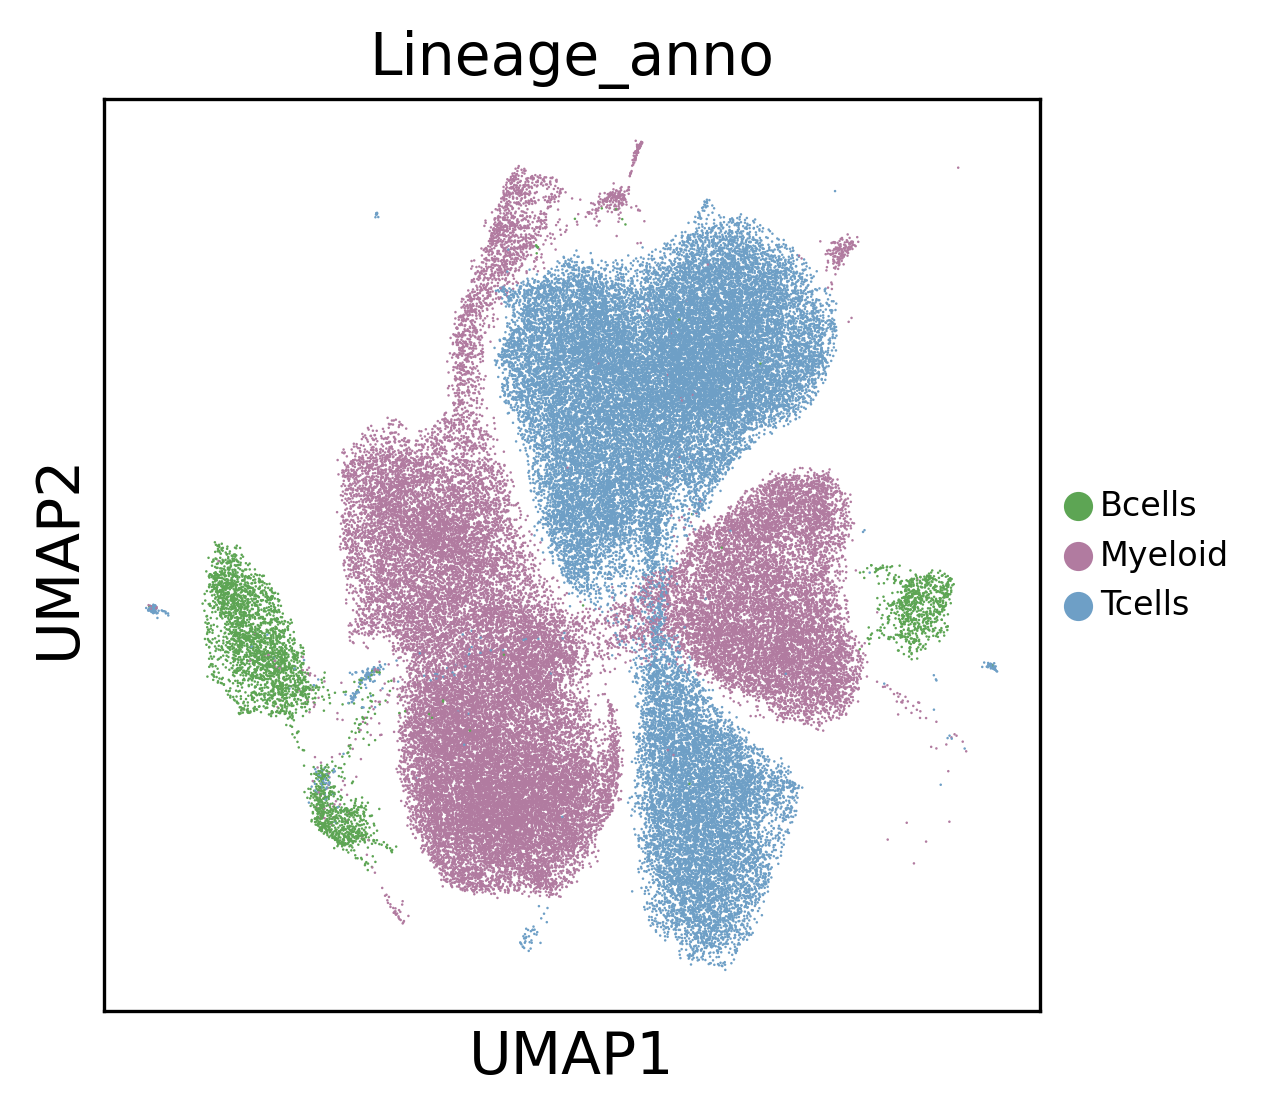

In [12]:
sc.pl.umap(adata_immune, color=["Lineage_anno"],
           palette= {'Tcells' : "#6e9fc6","Bcells":"#5da554",  "Myeloid":"#b17ba0" },
           legend_fontoutline=1, legend_fontsize=8)

In [13]:
adata_immune.write(storage_path + 'Lung_Immune_overview.h5ad' )

# Read preprocessed object and alpha values

In [4]:
adata_immune = sc.read_h5ad(storage_path + 'Lung_Immune_overview.h5ad')


In [5]:
adata_immune.obs.Material.value_counts()

cells     68245
nuclei    13935
Name: Material, dtype: int64

In [6]:
adata_immune.obs["Celltypes"] = adata_immune.obs["Celltypes"].str.replace(r"[/ &]","_").astype('category')
adata_immune.obs["Celltypes"].cat.categories

/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Index(['B_memory', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast',
       'CD4_EM_Effector', 'CD4_TRM', 'CD4_naive_CM', 'CD8_EM', 'CD8_EM_EMRA',
       'CD8_TRM', 'CD8_TRM_EM', 'DC_1', 'DC_2', 'DC_activated',
       'DC_plasmacytoid', 'ILC', 'MAIT', 'Macro_AW_CX3CR1', 'Macro_CCL',
       'Macro_CHIT1', 'Macro_alveolar', 'Macro_alveolar_metallothioneins',
       'Macro_dividing', 'Macro_intermediate', 'Macro_interstitial',
       'Macro_intravascular', 'Megakaryocyte', 'Monocyte_CD14',
       'Monocyte_CD16', 'NKT', 'NK_CD11d', 'NK_CD16hi', 'NK_CD56bright',
       'T_reg', 'gdT'],
      dtype='object')

In [7]:
adata_immune = adata_immune[adata_immune.obs['Celltypes'].isin(['B_memory', 'B_naive', 'B_plasma_IgA',
                    'B_plasma_IgG', 'B_plasmablast', 'CD4_naive_CM', 'CD8_EM', 
                    'CD8_EM_EMRA', 'CD8_TRM', 'DC_1', 'DC_2', 'DC_activated',
                    'DC_plasmacytoid', 'Macro_AW_CX3CR1', 'Macro_CHIT1', 'Macro_alveolar', 
                    'Macro_intermediate', 'Macro_interstitial','Macro_intravascular',
                    'Monocyte_CD14', 'Monocyte_CD16', 'NK_CD11d', 'NK_CD16hi', 'NK_CD56bright','T_reg'])]

In [8]:
adata_immune.obs["Celltypes"].cat.categories

Index(['B_memory', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast',
       'CD4_naive_CM', 'CD8_EM', 'CD8_EM_EMRA', 'CD8_TRM', 'DC_1', 'DC_2',
       'DC_activated', 'DC_plasmacytoid', 'Macro_AW_CX3CR1', 'Macro_CHIT1',
       'Macro_alveolar', 'Macro_intermediate', 'Macro_interstitial',
       'Macro_intravascular', 'Monocyte_CD14', 'Monocyte_CD16', 'NK_CD11d',
       'NK_CD16hi', 'NK_CD56bright', 'T_reg'],
      dtype='object')

In [9]:
alpha_dir = "/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/results/lung/"
alpha_vals = pd.read_csv(alpha_dir + "abcmk.txt", sep=",")

In [10]:
alpha_vals

line                 cell  α_weak  α_strong      α  ωₐ_weak  ωₐ_strong  \
0    Bcells             B_memory   0.050     0.131  0.280    0.016      0.048   
1    Bcells              B_naive   0.073     0.188  0.435    0.007      0.040   
2    Bcells         B_plasma_IgA   0.094     0.099  0.213    0.017      0.021   
3    Bcells         B_plasma_IgG   0.093     0.168  0.405    0.021      0.052   
4    Bcells        B_plasmablast   0.036     0.045  0.121    0.006      0.009   
5   Myeloid                 DC_1   0.025     0.046  0.099    0.011      0.014   
6   Myeloid                 DC_2   0.058     0.149  0.344    0.017      0.047   
7   Myeloid         DC_activated   0.098     0.220  0.364    0.017      0.062   
8   Myeloid      DC_plasmacytoid   0.042     0.104  0.283    0.018      0.047   
9   Myeloid      Macro_AW_CX3CR1   0.066     0.252  0.364    0.013      0.051   
10  Myeloid          Macro_CHIT1   0.033     0.062  0.129    0.007      0.017   
11  Myeloid       Macro_alveolar   0.030     0.052  0.108    0.005      0.012   
12  Myeloid   Macro_intermediate   0.010     0.025  0.055    0.008      0.013   
13  Myeloid   Macro_interstitial   0.019     0.042  0.096    0.005      0.009   
14  Myeloid  Macro_intravascular   0.051     0.109  0.196    0.010      0.030   
15  Myeloid        Monocyte_CD14   0.063     0.116  0.262    0.019      0.039   
16  Myeloid        Monocyte_CD16   0.089     0.135  0.314    0.018      0.050   
17   Tcells         CD4_naive_CM   0.029     0.034  0.084    0.006      0.006   
18   Tcells          CD8_EM_EMRA   0.055     0.092  0.213    0.017      0.025   
19   Tcells               CD8_EM   0.030     0.054  0.155    0.008      0.015   
20   Tcells              CD8_TRM   0.129     0.126  0.312    0.016      0.032   
21   Tcells             NK_CD11d   0.019     0.042  0.090    0.008      0.017   
22   Tcells            NK_CD16hi   0.114     0.182  0.359    0.027      0.050   
23   Tcells        NK_CD56bright   0.058     0.327  0.551    0.057      0.165   
24   Tcells                T_reg   0.136     0.187  0.446    0.014      0.037   

       ωₐ    ωₙₐ        γ₋      β     γ₊       γ₊₊      B  
0   0.081  0.221   989.765  0.207  7.100   595.274  0.395  
1   0.086  0.154   378.532  0.287  5.056  1578.281  0.338  
2   0.050  0.219   724.638  0.218  1.879  1534.337  0.375  
3   0.126  0.185  1188.724  0.240  6.206   452.895  0.457  
4   0.031  0.245   454.406  0.198  1.660  1211.312  0.296  
5   0.057  0.324   969.957  0.147  5.366   801.647  0.298  
6   0.097  0.213   684.989  0.216  2.048  1270.970  0.370  
7   0.090  0.170   871.061  0.242  9.394   919.941  0.397  
8   0.102  0.298  1062.776  0.157  2.290   462.639  0.290  
9   0.070  0.143  1707.885  0.268  8.857  1320.673  0.437  
10  0.045  0.288  1294.084  0.162  1.915  1442.254  0.296  
11  0.032  0.252   782.438  0.179  1.927   670.454  0.313  
12  0.035  0.332   813.327  0.134  1.545  1411.577  0.201  
13  0.030  0.228   460.445  0.208  2.996   774.101  0.227  
14  0.062  0.248  1097.039  0.196  7.080   830.194  0.327  
15  0.087  0.266   575.537  0.179  2.165   859.419  0.448  
16  0.100  0.232   489.602  0.176  5.136   666.352  0.367  
17  0.020  0.196   637.325  0.218  1.541   789.764  0.307  
18  0.064  0.234  1119.680  0.213  7.564  1072.660  0.340  
19  0.044  0.262  1352.903  0.184  2.999   481.821  0.236  
20  0.070  0.168   596.968  0.234  6.882  1081.850  0.420  
21  0.035  0.308   806.291  0.166  1.708   467.512  0.294  
22  0.112  0.223  1791.956  0.186  1.808   440.244  0.391  
23  0.250  0.181   754.305  0.208  8.906  1386.949  0.893  
24  0.108  0.137  1296.334  0.287  2.721  1444.099  0.373

In [11]:
adata_immune.obs["alpha"] = float('NaN')
for i in alpha_vals["cell"]:
    #print(i)
    adata_immune.obs["alpha"][adata_immune.obs["Celltypes"] == i] = float(alpha_vals["α"][alpha_vals["cell"] == i])

/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


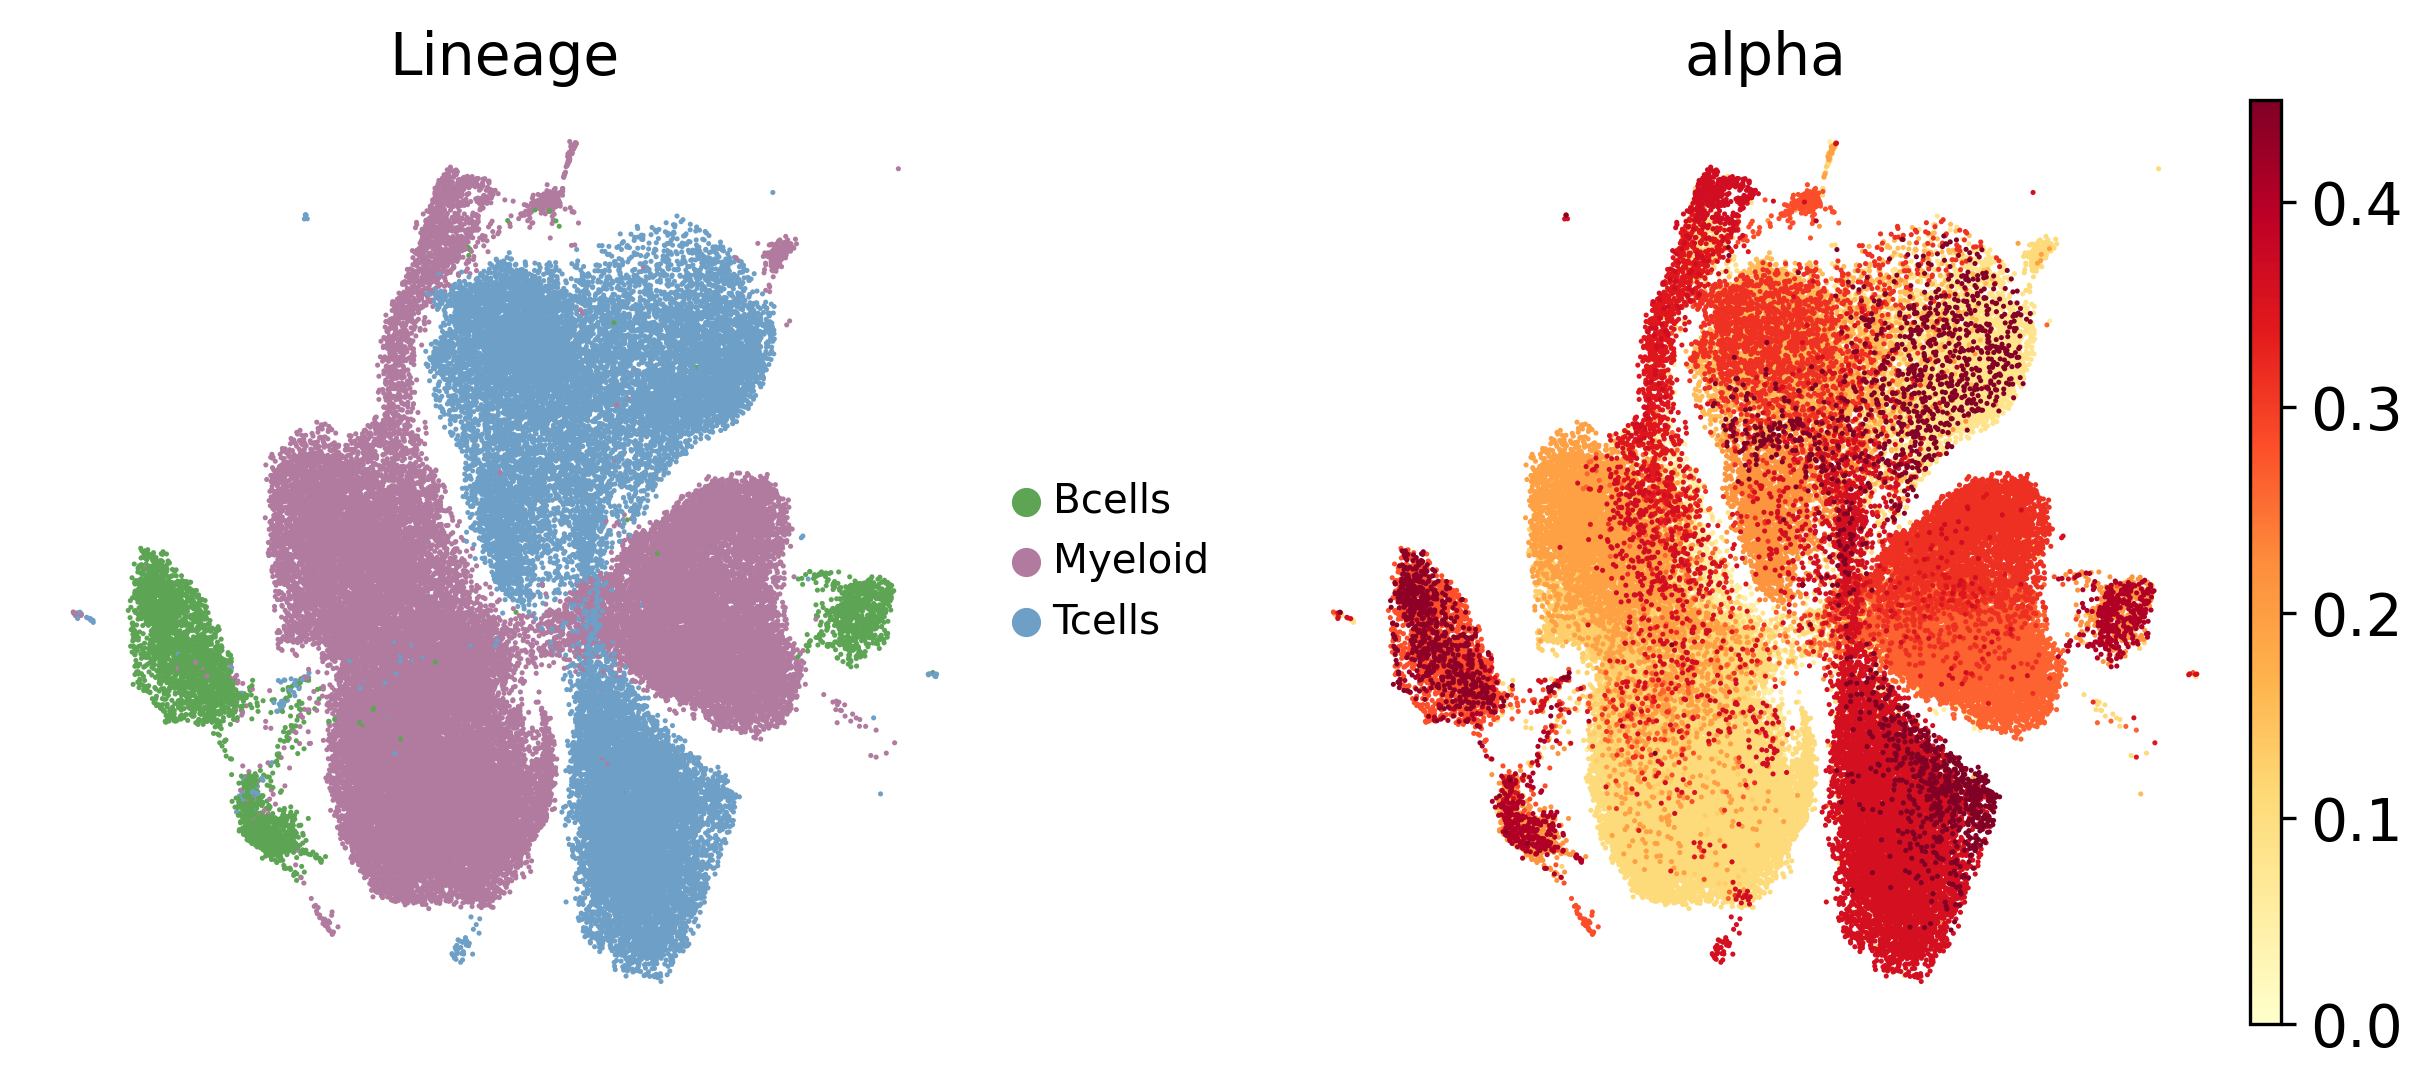

In [16]:
sc.pl.umap(adata_immune, color=["Lineage_anno", "alpha"],save= "Lung_overview_2.svg",
           palette= {'Tcells' : "#6e9fc6","Bcells":"#5da554",  "Myeloid":"#b17ba0" },
           color_map=matplotlib.cm.YlOrRd, vmax = 0.45, vmin= 0,
           legend_loc = 'right margin',legend_fontoutline =1, 
           frameon= False, title= "Lineage", size = 6,
           legend_fontsize= 'x-small', na_in_legend = False )